# TermProject - 2013104219 이준형


## 주제 선정 이유: 

현재 운영 중인 에어비앤비 숙소의 가격을 산정하는 과정에서 어떻게 하면 임대 수익을 극대화할 수 있을까 고민을 하던 중, Dynamic Pricing을 위한 알고리즘이 있다는 것을 알게 되었다. 이후 Dynamic Pricing을 제공하는 서비스를 찾았으나 대부분 미국 혹은 유럽의 주요 대도시만 지원이 되고 국내 지원이 되는 서비스가 존재하지 않았다. 그래서 직접 에어비앤비의 숙소 정보를 수집해서 분석하기로 결정했다.

## 가설:

같은 지역에 위치한 숙소들 중 특정 조건이 비슷한 숙소끼리는 숙박료가 비슷할 것이며, 이를 바탕으로 운영 중인 에어 비앤비 숙소의 '적정 가격'을 산출할 수 있을 것이다.

## 데이터 획득:

크롤러를 사용하여 에어 비앤비에 지역, 체크인/체크아웃 날짜를 주고 엑셀 데이터로 저장했다.

## 데이터 가공:

데이터를 트레이닝 셋과 테스트 셋으로 나눈 뒤 모델을 학습시켰다.

## 분석 결과:

특징이 비슷한 숙소끼리는 가격이 비슷하게 수렴하는 현상이 발생했으나 상대적으로 고가의 숙소 혹은 방이 많은 숙소 등의 가격을 예측하는데는 실패했다.

이는 이런 숙소들이 예외적인 요소이기 때문이며, 충분하게 데이터를 많이 수집한다면 오차 범위를 줄일 수 있을 것이다.

## 결론:

지역의 일반적인 숙소 (침실1, 침대1, 수용인원 4인 내외)의 경우 비교 대상이 많으므로 오차가 가장 적은 결과를 얻을 수 있었다.

다만 유명한 숙소(고급 호텔 등)이나 대형 숙소(수용인원 8인 이상 혹은 침실 4개 이상)의 경우에는 가격 오차가 크게 발생했다.

이는 숙소의 브랜드 가치 혹은 썸네일 등의 평가를 반영하기 어렵기 때문이다.

그리고 또 한 가지 고려해봐야할 점은 계절성(Seasonality)이다. 

같은 숙소라 하더라도 일 년 중 특정 이벤트가 몰려있는 시기에 가격이 훨씬 불규칙적으로 움직인다.

다른 개선점으로는 '텍스트 데이터'의 카테고라화(Categorization) 이다.

숙소 안내 문구, 후기, 호텔 물품(Ammenities) 등에 대한 자연어 분석을 통해서 숙소 비교에 새로운 기능으로 추가할 수 있다.

## 참고:

- [Machine Learning Fundamentals: Predicting Airbnb Prices](https://www.dataquest.io/blog/machine-learning-tutorial/)
- [Making Models (I) | Airbnb Price Prediction: Data Analysis
](https://medium.com/@philmohun/making-models-airbnb-price-prediction-data-analysis-15b9af87c9d8)

## 원본 데이터:

- 숙소의 가격 데이터 엑셀 파일
            

춘천, 포항, 홍대, 수원, 강남 5 지역의 데이터가 있습니다. 어떤 지역을 고르시겠습니까?수원
얼마나 많은 숙소의 가격 정보를 비교하시겠습니까?12


/Users/leejunhyung/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


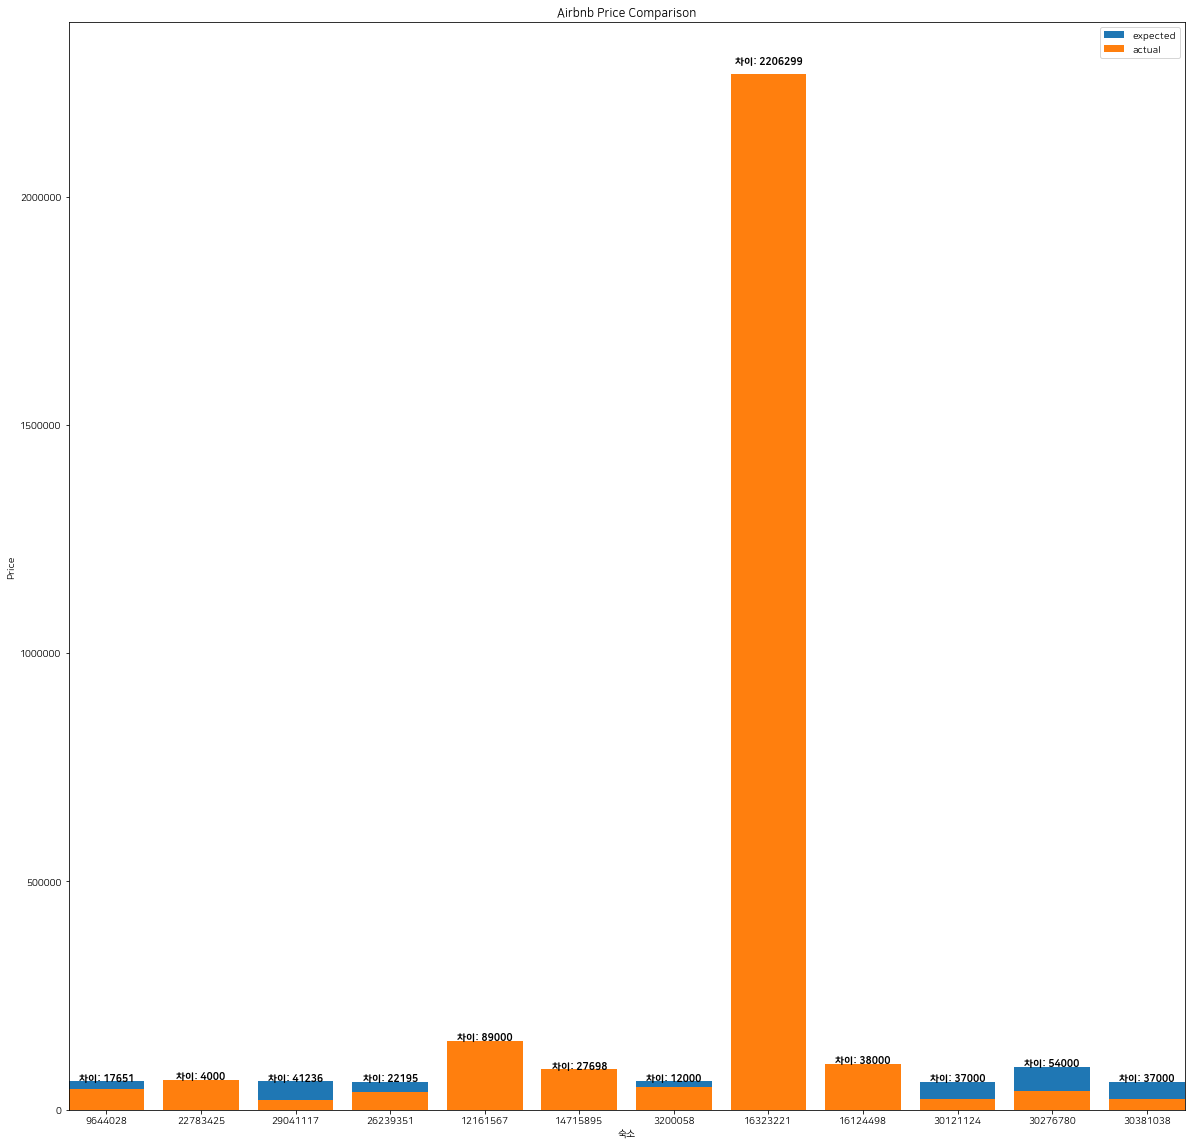

In [48]:
"""
비슷한 성질을 가진 집단을 분류하는 알고리즘 중 하나인 KNN(K-Nearest-Neighbors)를 사용하여 
특정 지역의 에어비앤비 숙소의 적정 가격을 산정
"""
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from datetime import datetime, date
import matplotlib.pyplot as plt
from matplotlib import font_manager

def prepare_data(name):
    listings = pd.read_excel(f'{name}.xlsx')

    features = """
    accomodates bathrooms bedrooms beds nightly_price number_of_reviews id
    """.strip().split(' ')

    listings = listings[features]

    # shuffle listings
    listings = listings.sample(frac=1,random_state=0)

    for col in listings:
        if not (col == 'nightly_price' or col == 'id'):
            listings[col] = scale(listings[col])
    
    return listings

def predict(data):
    size_test = int(len(data) * 0.25)
    
    train_df = data.copy().iloc[:size_test]
    test_df = data.copy().iloc[size_test:]
 
    knn = KNeighborsRegressor(algorithm='brute', n_neighbors=5)

    cols = ['accomodates', 'bathrooms', 'bedrooms', 'beds']

    knn.fit(train_df[cols], train_df['nightly_price'])
    predictions = knn.predict(test_df[cols])
    mse = mean_squared_error(test_df['nightly_price'], predictions)
    rmse = mse ** (1/2)
    
    test_df['expected'] = [round(x / 1000) * 1000 for x in predictions]
    test_df['diff'] = test_df['expected'] - test_df['nightly_price']
    
    return test_df

def draw_graph(result, how_many):
    CHART_SIZE_X = 20
    CHART_SIZE_Y = 20
    
    plt.figure(figsize=(CHART_SIZE_X, CHART_SIZE_Y))
    
    displayed = result[:how_many]
    range_displayed = range(len(result[:how_many]))
    
    font_fname = '/Library/Fonts/NanumSquareRoundOTFB.otf'
    font_family = font_manager.FontProperties(fname=font_fname).get_name()
    
    plt.rcParams['font.family'] = font_family
    
    plt.bar(range_displayed, displayed['expected'])
    plt.bar(range_displayed, displayed['nightly_price'])
    plt.xticks(range_displayed, displayed['id'])

    for i, v in enumerate(list(displayed['expected'])):
        expected = list(displayed['expected'])[i]
        actual = list(displayed['nightly_price'])[i]
        diff = int(abs(expected - actual))
        
        position = max(expected, actual) * 1.01
        
        plt.text(i, position, str(f'차이: {diff}'), color='black', fontweight='bold', horizontalalignment='center')
    
    plt.ylabel('Price')
    plt.xlabel('숙소')
    plt.title('Airbnb Price Comparison')
    plt.legend(['expected', 'actual'])
    plt.autoscale(enable=True, axis='x', tight=True)    
    
def main():  
    while True:
        listing_files = {
            '춘천': 'listing-춘천-2018-12-03 20-15', 
            '포항': 'listing-포항-2018-11-27 17-13',
            '홍대': 'listing-홍대-2018-12-05 19-12',
            '수원': 'listing-수원-2018-12-05 19-36',
            '강남': 'listing-강남-2018-12-05 19-50',
        }
            
        city = input(f'{", ".join(listing_files.keys())} {len(listing_files.keys())} 지역의 데이터가 있습니다. 어떤 지역을 고르시겠습니까?')
        how_many = 10
        
        try:
            how_many = int(input('얼마나 많은 숙소의 가격 정보를 비교하시겠습니까?'))
        except ValueError:
            print('잘못된 숫자입니다. 기본값인 10개를 보여줍니다.')

        if city in listing_files.keys():
            listings = prepare_data(listing_files[city]) 
            result = predict(listings) 
            draw_graph(result, how_many)
            break

main()